In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
from torchinfo import summary
import torch.optim as optim
import numpy as np
import h5py
import os
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should print the device index (e.g., 0)
print(torch.cuda.get_device_name(0))  # S

True
0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class GanglionCellDataset(Dataset):
    def __init__(self, h5_file):
        
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as f:
            self.stimuli = np.array(f['train/stimulus'])  # (359802, 50, 50)
            self.responses = np.array(f['train/response/firing_rate_10ms'])  # (9, 359802)

        # Reshape stimuli to (N, 1, H, W) for CNN
        self.stimuli = self.stimuli[:, np.newaxis, :, :].astype(np.float32)  # (359802, 1, 50, 50)

        # Transpose responses to match sample dimension
        self.responses = self.responses.T.astype(np.float32)  # (359802, 9)

    def __len__(self):
        return len(self.stimuli)

    def __getitem__(self, idx):
        stimuli = torch.tensor(self.stimuli[idx], device=DEVICE)  # Move to device
        responses = torch.tensor(self.responses[idx], device=DEVICE)  # Move to device
        return stimuli, responses

In [4]:
class GaussianNoise(nn.Module):
    def __init__(self, std: float):
        super(GaussianNoise, self).__init__()
        self.std = std

    def forward(self, x):
        if self.training:  # Only apply noise during training
            noise = torch.randn_like(x).to(x.device) * self.std  # Ensure noise is on the same device
            return x + noise
        return x

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)  # Flatten the input tensor

class Exponential(nn.Module):
    def __init__(self, train_off=False):
        super(Exponential, self).__init__()
        self.train_off = train_off

    def forward(self, x):
        if self.train_off:
            return torch.exp(x)  # Example: Exponential activation without training
        else:
            return torch.exp(x)  # Modify as needed based on the desired behavior

In [5]:
class TDRModel(nn.Module):
    """
    Base class for most models. Handles setting most of the member
    variables that are shared for most model definitions.
    """
    def __init__(self, n_units=5, noise=.05, bias=True, gc_bias=None,
                 chans=[8,8], bn_moment=.01, softplus=True,
                 inference_exp=False, img_shape=(40,50,50),
                 ksizes=(15,11,11), recurrent=False, kinetic=False,
                 convgc=False, centers=None, bnorm_d=1,
                 activ_fxn='ReLU', **kwargs):
        """
        Initializes common parameters for retinal models.
        """
        super().__init__()
        self.n_units = n_units
        self.chans = chans
        self.softplus = softplus
        self.infr_exp = inference_exp
        self.bias = bias
        self.img_shape = img_shape
        self.ksizes = ksizes
        self.gc_bias = gc_bias
        self.noise = noise
        self.bn_moment = bn_moment
        self.recurrent = recurrent
        self.kinetic = kinetic
        self.convgc = convgc
        self.centers = centers
        self.bnorm_d = bnorm_d
        assert bnorm_d in [1, 2], "Only 1D and 2D batchnorm are supported."
        self.activ_fxn = activ_fxn

    def forward(self, x):
        """
        This function should be implemented in child classes.
        """
        raise NotImplementedError("Forward function must be implemented in child class.")

    def update_shape(self, shape, kernel_size):
        """
        Helper function to update spatial dimensions after convolution.

        Parameters:
        - shape: tuple (height, width)
        - kernel_size: int or tuple

        Returns:
        - New shape after convolution
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        h_out = shape[0] - kernel_size[0] + 1
        w_out = shape[1] - kernel_size[1] + 1
        return (h_out, w_out)

    def extra_repr(self):
        """
        This function is used in model printing. Shows model parameters.
        """
        s = ['n_units={}', 'noise={}', 'bias={}', 'gc_bias={}',
             'chans={}', 'bn_moment={}', 'softplus={}',
             'inference_exp={}', 'img_shape={}', 'ksizes={}']
        return ", ".join(s).format(self.n_units, self.noise, self.bias,
                                   self.gc_bias, self.chans,
                                   self.bn_moment, self.softplus,
                                   self.infr_exp, self.img_shape, self.ksizes)

    def requires_grad(self, state: bool):
        """
        Enables or disables gradient calculations.

        Parameters:
        - state (bool): True to enable gradients, False to disable.
        """
        for p in self.parameters():
            p.requires_grad = state

In [6]:
# Exact BNCNN Model
class BNCNN(TDRModel):
    """
    BatchNorm CNN for predicting ganglion cell responses.
    """

    def __init__(self, gauss_prior=0, **kwargs):
        super().__init__(**kwargs)
        self.name = 'McNiruNet'
        self.gauss_prior = gauss_prior
        modules = []
        self.shapes = []
        shape = self.img_shape[1:]

        modules.append(nn.Conv2d(self.img_shape[0], self.chans[0], kernel_size=self.ksizes[0], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[0])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[0] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[0], *shape)))
        else:
            modules.append(nn.BatchNorm2d(self.chans[0], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        modules.append(nn.Conv2d(self.chans[0], self.chans[1], kernel_size=self.ksizes[1], bias=self.bias))
        shape = self.update_shape(shape, self.ksizes[1])
        self.shapes.append(tuple(shape))

        if self.bnorm_d == 1:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.BatchNorm1d(size, eps=1e-3, momentum=self.bn_moment))
            modules.append(Reshape((-1, self.chans[1], shape[0], shape[1])))
        else:
            modules.append(nn.BatchNorm2d(self.chans[1], eps=1e-3, momentum=self.bn_moment))

        modules.append(GaussianNoise(std=self.noise))
        modules.append(getattr(nn, self.activ_fxn)())

        if self.convgc:
            modules.append(nn.Conv2d(self.chans[1], self.n_units, kernel_size=self.ksizes[2], bias=self.gc_bias))
            shape = self.update_shape(shape, self.ksizes[2])
            self.shapes.append(tuple(shape))
            modules.append(GrabUnits(self.centers, self.ksizes, self.img_shape))
        else:
            modules.append(Flatten())
            size = self.chans[1] * shape[0] * shape[1]
            modules.append(nn.Linear(size, self.n_units, bias=self.gc_bias))

        modules.append(nn.BatchNorm1d(self.n_units, eps=1e-3, momentum=self.bn_moment))

        if self.softplus:
            modules.append(nn.Softplus())
        else:
            modules.append(Exponential(train_off=True))

        self.sequential = nn.Sequential(*modules)

        if self.gauss_prior > 0:
            for i, seq_idx in enumerate([0, 6]):
                weight = self.sequential[seq_idx].weight
                filters = []
                for out_i in range(weight.shape[0]):
                    kernels = []
                    for in_i in range(weight.shape[1]):
                        prior_x = signal.gaussian(weight.shape[-1], std=self.gauss_prior)
                        prior_y = signal.gaussian(weight.shape[-2], std=self.gauss_prior)
                        prior = np.outer(prior_y, prior_x)
                        kernels.append(prior)
                    filters.append(np.asarray(kernels))
                prior = np.asarray(filters)
                denom = np.sqrt(weight.shape[0] + weight.shape[1])
                prior = prior / np.max(prior) / denom
                prior = torch.FloatTensor(prior)
                self.sequential[seq_idx].weight.data = prior

    def forward(self, x):
        if not self.training and self.infr_exp:
            return torch.exp(self.sequential(x))
        return self.sequential(x)

In [7]:
def train_model(h5_file, hyperparams, batch_size=32, lr=0.001, epochs=100, val_split=0.1):
    dataset = GanglionCellDataset(h5_file)
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = BNCNN(**hyperparams).to(DEVICE)
    loss_fn = nn.PoissonNLLLoss(log_input=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    writer = SummaryWriter(log_dir="runs/bncnn_experiment")

    loss_history, accuracy_history = [], []
    val_loss_history, val_accuracy_history = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, train_acc, train_count = 0, 0, 0
        all_predictions, all_targets = [], []

        for stimuli, firing_rate in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
            optimizer.zero_grad()
            predictions = model(stimuli)
            loss = loss_fn(predictions, firing_rate)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            pred_np, target_np = predictions.detach().cpu().numpy(), firing_rate.detach().cpu().numpy()
            
            correlations = [
                np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                for i in range(9)
            ]
            correlation = np.mean(correlations)
            train_acc += correlation
            train_count += 1
            all_predictions.append(pred_np)
            all_targets.append(target_np)

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = train_acc / train_count if train_count > 0 else 0
        loss_history.append(avg_train_loss)
        accuracy_history.append(avg_train_acc)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)

        model.eval()
        val_loss, val_acc, val_count = 0, 0, 0
        all_val_predictions, all_val_targets = [], []

        with torch.no_grad():
            for stimuli, firing_rate in val_loader:
                stimuli, firing_rate = stimuli.to(DEVICE), firing_rate.to(DEVICE)
                predictions = model(stimuli)
                loss = loss_fn(predictions, firing_rate)
                val_loss += loss.item()
                
                pred_np, target_np = predictions.cpu().numpy(), firing_rate.cpu().numpy()
                correlations = [
                    np.corrcoef(pred_np[:, i], target_np[:, i])[0, 1] if np.std(pred_np[:, i]) > 0 and np.std(target_np[:, i]) > 0 else 0
                    for i in range(9)
                ]
                correlation = np.mean(correlations)
                val_acc += correlation
                val_count += 1
                all_val_predictions.append(pred_np)
                all_val_targets.append(target_np)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_acc)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", avg_val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Train Acc: {avg_train_acc:.4f}, "
              f"Val Loss: {avg_val_loss:.6f}, Val Acc: {avg_val_acc:.4f}")

    torch.save(model.state_dict(), "bncnn_model.pth")
    print("Model saved to bncnn_model.pth")

    channels, height, width = 1, 50, 50
    # Print model summary
    summary_str = str(summary(model, input_size=(batch_size, 1, 50, 50), depth=10, verbose=2))
    # print(summary_str)

    all_predictions = np.vstack(all_predictions)
    all_targets = np.vstack(all_targets)
    all_val_predictions = np.vstack(all_val_predictions)
    all_val_targets = np.vstack(all_val_targets)
    
    print(f"Final Training Loss: {loss_history[-1]:.6f}")
    print(f"Final Training Accuracy: {accuracy_history[-1]:.4f}")
    print(f"Final Validation Loss: {val_loss_history[-1]:.6f}")
    print(f"Final Validation Accuracy: {val_accuracy_history[-1]:.4f}")
    print(f"Shape of final training prediction array: {all_predictions.shape}")
    print(f"Shape of final training actual array: {all_targets.shape}")
    print(f"Shape of final validation prediction array: {all_val_predictions.shape}")
    print(f"Shape of final validation actual array: {all_val_targets.shape}")

    
    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Train Loss")
    plt.plot(range(epochs), val_loss_history, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), accuracy_history, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracy_history, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()
    
    # Plot True vs. Predicted for 9 neurons
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    time_steps = np.arange(all_targets.shape[0])  
    
    for i, ax in enumerate(axes.flat):
        ax.plot(time_steps, all_targets[:, i], label="True", linestyle="-", color="blue", alpha=0.7)
        ax.plot(time_steps, all_predictions[:, i], label="Predicted", linestyle="--", color="red", alpha=0.7)
        
        ax.set_xlabel("Time (Image Index)")
        ax.set_ylabel("Firing Rate")
        ax.set_title(f"Neuron {i+1}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

Epoch 1/100: 100%|██████████| 10120/10120 [04:27<00:00, 37.82it/s]


Epoch 1/100, Train Loss: -0.104366, Train Acc: 0.1301, Val Loss: -0.254232, Val Acc: 0.1605


Epoch 2/100: 100%|██████████| 10120/10120 [03:08<00:00, 53.77it/s]


Epoch 2/100, Train Loss: -0.445230, Train Acc: 0.1952, Val Loss: -0.516100, Val Acc: 0.2200


Epoch 3/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.45it/s]


Epoch 3/100, Train Loss: -0.930850, Train Acc: 0.2847, Val Loss: -0.882385, Val Acc: 0.2920


Epoch 4/100: 100%|██████████| 10120/10120 [02:43<00:00, 61.87it/s]


Epoch 4/100, Train Loss: -1.366206, Train Acc: 0.3493, Val Loss: -1.119054, Val Acc: 0.3293


Epoch 5/100: 100%|██████████| 10120/10120 [03:03<00:00, 55.03it/s]


Epoch 5/100, Train Loss: -1.629947, Train Acc: 0.3852, Val Loss: -1.238908, Val Acc: 0.3482


Epoch 6/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.31it/s]


Epoch 6/100, Train Loss: -1.813260, Train Acc: 0.4088, Val Loss: -1.407279, Val Acc: 0.3651


Epoch 7/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.66it/s]


Epoch 7/100, Train Loss: -1.930853, Train Acc: 0.4224, Val Loss: -1.401805, Val Acc: 0.3785


Epoch 8/100: 100%|██████████| 10120/10120 [02:26<00:00, 69.23it/s]


Epoch 8/100, Train Loss: -2.024673, Train Acc: 0.4350, Val Loss: -1.509250, Val Acc: 0.3852


Epoch 9/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.82it/s]


Epoch 9/100, Train Loss: -2.100329, Train Acc: 0.4441, Val Loss: -1.593000, Val Acc: 0.3912


Epoch 10/100: 100%|██████████| 10120/10120 [04:01<00:00, 41.89it/s]


Epoch 10/100, Train Loss: -2.166419, Train Acc: 0.4509, Val Loss: -1.593283, Val Acc: 0.3968


Epoch 11/100: 100%|██████████| 10120/10120 [04:45<00:00, 35.40it/s]


Epoch 11/100, Train Loss: -2.215891, Train Acc: 0.4572, Val Loss: -1.663118, Val Acc: 0.4032


Epoch 12/100: 100%|██████████| 10120/10120 [03:17<00:00, 51.19it/s]


Epoch 12/100, Train Loss: -2.256639, Train Acc: 0.4606, Val Loss: -1.555866, Val Acc: 0.4039


Epoch 13/100: 100%|██████████| 10120/10120 [02:28<00:00, 68.38it/s]


Epoch 13/100, Train Loss: -2.296374, Train Acc: 0.4661, Val Loss: -1.728254, Val Acc: 0.4089


Epoch 14/100: 100%|██████████| 10120/10120 [02:46<00:00, 60.91it/s]


Epoch 14/100, Train Loss: -2.325625, Train Acc: 0.4686, Val Loss: -1.612981, Val Acc: 0.4110


Epoch 15/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.27it/s]


Epoch 15/100, Train Loss: -2.361726, Train Acc: 0.4732, Val Loss: -1.826402, Val Acc: 0.4192


Epoch 16/100: 100%|██████████| 10120/10120 [02:32<00:00, 66.55it/s]


Epoch 16/100, Train Loss: -2.389085, Train Acc: 0.4763, Val Loss: -1.859564, Val Acc: 0.4196


Epoch 17/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.92it/s]


Epoch 17/100, Train Loss: -2.418628, Train Acc: 0.4806, Val Loss: -1.824957, Val Acc: 0.4263


Epoch 18/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.77it/s]


Epoch 18/100, Train Loss: -2.440110, Train Acc: 0.4826, Val Loss: -1.914400, Val Acc: 0.4269


Epoch 19/100: 100%|██████████| 10120/10120 [03:11<00:00, 52.73it/s]


Epoch 19/100, Train Loss: -2.464303, Train Acc: 0.4852, Val Loss: -1.889652, Val Acc: 0.4270


Epoch 20/100: 100%|██████████| 10120/10120 [03:07<00:00, 54.04it/s]


Epoch 20/100, Train Loss: -2.487976, Train Acc: 0.4867, Val Loss: -1.933853, Val Acc: 0.4264


Epoch 21/100: 100%|██████████| 10120/10120 [02:48<00:00, 60.09it/s]


Epoch 21/100, Train Loss: -2.513649, Train Acc: 0.4903, Val Loss: -1.968486, Val Acc: 0.4304


Epoch 22/100: 100%|██████████| 10120/10120 [02:40<00:00, 63.15it/s]


Epoch 22/100, Train Loss: -2.532876, Train Acc: 0.4932, Val Loss: -1.946684, Val Acc: 0.4346


Epoch 23/100: 100%|██████████| 10120/10120 [02:49<00:00, 59.59it/s]


Epoch 23/100, Train Loss: -2.547626, Train Acc: 0.4939, Val Loss: -1.929561, Val Acc: 0.4301


Epoch 24/100: 100%|██████████| 10120/10120 [03:24<00:00, 49.50it/s]


Epoch 24/100, Train Loss: -2.562012, Train Acc: 0.4978, Val Loss: -1.939916, Val Acc: 0.4314


Epoch 25/100: 100%|██████████| 10120/10120 [03:02<00:00, 55.47it/s]


Epoch 25/100, Train Loss: -2.578846, Train Acc: 0.4989, Val Loss: -1.961950, Val Acc: 0.4355


Epoch 26/100: 100%|██████████| 10120/10120 [03:15<00:00, 51.68it/s]


Epoch 26/100, Train Loss: -2.595592, Train Acc: 0.5006, Val Loss: -1.989224, Val Acc: 0.4402


Epoch 27/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.19it/s]


Epoch 27/100, Train Loss: -2.611331, Train Acc: 0.5041, Val Loss: -2.016515, Val Acc: 0.4429


Epoch 28/100: 100%|██████████| 10120/10120 [02:37<00:00, 64.23it/s]


Epoch 28/100, Train Loss: -2.625777, Train Acc: 0.5033, Val Loss: -2.038692, Val Acc: 0.4433


Epoch 29/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.52it/s]


Epoch 29/100, Train Loss: -2.635540, Train Acc: 0.5049, Val Loss: -2.020407, Val Acc: 0.4437


Epoch 30/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.36it/s]


Epoch 30/100, Train Loss: -2.653896, Train Acc: 0.5072, Val Loss: -2.051988, Val Acc: 0.4428


Epoch 31/100: 100%|██████████| 10120/10120 [02:33<00:00, 66.11it/s]


Epoch 31/100, Train Loss: -2.665532, Train Acc: 0.5091, Val Loss: -1.959571, Val Acc: 0.4434


Epoch 32/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.60it/s]


Epoch 32/100, Train Loss: -2.671668, Train Acc: 0.5096, Val Loss: -2.143285, Val Acc: 0.4491


Epoch 33/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.57it/s]


Epoch 33/100, Train Loss: -2.684756, Train Acc: 0.5122, Val Loss: -2.122823, Val Acc: 0.4459


Epoch 34/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.95it/s]


Epoch 34/100, Train Loss: -2.692527, Train Acc: 0.5125, Val Loss: -2.017942, Val Acc: 0.4503


Epoch 35/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.46it/s]


Epoch 35/100, Train Loss: -2.705898, Train Acc: 0.5136, Val Loss: -2.108673, Val Acc: 0.4521


Epoch 36/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.41it/s]


Epoch 36/100, Train Loss: -2.711747, Train Acc: 0.5142, Val Loss: -2.112997, Val Acc: 0.4488


Epoch 37/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.51it/s]


Epoch 37/100, Train Loss: -2.721837, Train Acc: 0.5151, Val Loss: -2.031918, Val Acc: 0.4479


Epoch 38/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.07it/s]


Epoch 38/100, Train Loss: -2.729425, Train Acc: 0.5163, Val Loss: -2.094661, Val Acc: 0.4557


Epoch 39/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.42it/s]


Epoch 39/100, Train Loss: -2.745268, Train Acc: 0.5180, Val Loss: -2.097972, Val Acc: 0.4545


Epoch 40/100: 100%|██████████| 10120/10120 [03:36<00:00, 46.72it/s]


Epoch 40/100, Train Loss: -2.750327, Train Acc: 0.5185, Val Loss: -1.977922, Val Acc: 0.4542


Epoch 41/100: 100%|██████████| 10120/10120 [03:07<00:00, 54.12it/s]


Epoch 41/100, Train Loss: -2.752644, Train Acc: 0.5200, Val Loss: -2.122961, Val Acc: 0.4543


Epoch 42/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.64it/s]


Epoch 42/100, Train Loss: -2.762500, Train Acc: 0.5203, Val Loss: -2.109297, Val Acc: 0.4555


Epoch 43/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.71it/s]


Epoch 43/100, Train Loss: -2.776929, Train Acc: 0.5236, Val Loss: -2.230935, Val Acc: 0.4597


Epoch 44/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.94it/s]


Epoch 44/100, Train Loss: -2.785664, Train Acc: 0.5236, Val Loss: -2.216262, Val Acc: 0.4585


Epoch 45/100: 100%|██████████| 10120/10120 [02:23<00:00, 70.71it/s]


Epoch 45/100, Train Loss: -2.779991, Train Acc: 0.5244, Val Loss: -2.144522, Val Acc: 0.4578


Epoch 46/100: 100%|██████████| 10120/10120 [02:52<00:00, 58.51it/s]


Epoch 46/100, Train Loss: -2.786554, Train Acc: 0.5243, Val Loss: -2.075899, Val Acc: 0.4566


Epoch 47/100: 100%|██████████| 10120/10120 [02:33<00:00, 66.12it/s]


Epoch 47/100, Train Loss: -2.799216, Train Acc: 0.5246, Val Loss: -2.235459, Val Acc: 0.4577


Epoch 48/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.84it/s]


Epoch 48/100, Train Loss: -2.802702, Train Acc: 0.5265, Val Loss: -2.178720, Val Acc: 0.4641


Epoch 49/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.97it/s]


Epoch 49/100, Train Loss: -2.814341, Train Acc: 0.5280, Val Loss: -2.152378, Val Acc: 0.4601


Epoch 50/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.96it/s]


Epoch 50/100, Train Loss: -2.812470, Train Acc: 0.5270, Val Loss: -2.271745, Val Acc: 0.4667


Epoch 51/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.94it/s]


Epoch 51/100, Train Loss: -2.818074, Train Acc: 0.5282, Val Loss: -2.266185, Val Acc: 0.4619


Epoch 52/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.95it/s]


Epoch 52/100, Train Loss: -2.822263, Train Acc: 0.5282, Val Loss: -2.292436, Val Acc: 0.4663


Epoch 53/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.45it/s]


Epoch 53/100, Train Loss: -2.833244, Train Acc: 0.5299, Val Loss: -2.318275, Val Acc: 0.4662


Epoch 54/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.52it/s]


Epoch 54/100, Train Loss: -2.834938, Train Acc: 0.5302, Val Loss: -2.107851, Val Acc: 0.4585


Epoch 55/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.91it/s]


Epoch 55/100, Train Loss: -2.844710, Train Acc: 0.5311, Val Loss: -2.308770, Val Acc: 0.4665


Epoch 56/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.36it/s]


Epoch 56/100, Train Loss: -2.841630, Train Acc: 0.5320, Val Loss: -2.298517, Val Acc: 0.4658


Epoch 57/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.19it/s]


Epoch 57/100, Train Loss: -2.843756, Train Acc: 0.5308, Val Loss: -2.255201, Val Acc: 0.4640


Epoch 58/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.18it/s]


Epoch 58/100, Train Loss: -2.854832, Train Acc: 0.5323, Val Loss: -2.303394, Val Acc: 0.4666


Epoch 59/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.13it/s]


Epoch 59/100, Train Loss: -2.859232, Train Acc: 0.5335, Val Loss: -2.192394, Val Acc: 0.4613


Epoch 60/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.15it/s]


Epoch 60/100, Train Loss: -2.861548, Train Acc: 0.5334, Val Loss: -2.285443, Val Acc: 0.4677


Epoch 61/100: 100%|██████████| 10120/10120 [02:26<00:00, 68.85it/s]


Epoch 61/100, Train Loss: -2.874159, Train Acc: 0.5354, Val Loss: -2.311610, Val Acc: 0.4668


Epoch 62/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.05it/s]


Epoch 62/100, Train Loss: -2.872341, Train Acc: 0.5339, Val Loss: -2.345191, Val Acc: 0.4721


Epoch 63/100: 100%|██████████| 10120/10120 [03:07<00:00, 53.98it/s]


Epoch 63/100, Train Loss: -2.872006, Train Acc: 0.5350, Val Loss: -2.359572, Val Acc: 0.4719


Epoch 64/100: 100%|██████████| 10120/10120 [02:45<00:00, 61.17it/s]


Epoch 64/100, Train Loss: -2.877240, Train Acc: 0.5349, Val Loss: -2.159022, Val Acc: 0.4668


Epoch 65/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.08it/s]


Epoch 65/100, Train Loss: -2.882410, Train Acc: 0.5356, Val Loss: -2.321048, Val Acc: 0.4708


Epoch 66/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.84it/s]


Epoch 66/100, Train Loss: -2.884216, Train Acc: 0.5362, Val Loss: -2.334378, Val Acc: 0.4708


Epoch 67/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.65it/s]


Epoch 67/100, Train Loss: -2.888072, Train Acc: 0.5370, Val Loss: -2.351313, Val Acc: 0.4675


Epoch 68/100: 100%|██████████| 10120/10120 [02:47<00:00, 60.45it/s]


Epoch 68/100, Train Loss: -2.889792, Train Acc: 0.5361, Val Loss: -2.349756, Val Acc: 0.4704


Epoch 69/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.43it/s]


Epoch 69/100, Train Loss: -2.897013, Train Acc: 0.5381, Val Loss: -2.352080, Val Acc: 0.4715


Epoch 70/100: 100%|██████████| 10120/10120 [02:39<00:00, 63.33it/s]


Epoch 70/100, Train Loss: -2.900523, Train Acc: 0.5380, Val Loss: -2.369053, Val Acc: 0.4691


Epoch 71/100: 100%|██████████| 10120/10120 [02:41<00:00, 62.73it/s]


Epoch 71/100, Train Loss: -2.904258, Train Acc: 0.5386, Val Loss: -2.360358, Val Acc: 0.4720


Epoch 72/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.83it/s]


Epoch 72/100, Train Loss: -2.905224, Train Acc: 0.5399, Val Loss: -2.338017, Val Acc: 0.4715


Epoch 73/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.54it/s]


Epoch 73/100, Train Loss: -2.908966, Train Acc: 0.5397, Val Loss: -2.366326, Val Acc: 0.4732


Epoch 74/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.94it/s]


Epoch 74/100, Train Loss: -2.907184, Train Acc: 0.5385, Val Loss: -2.360409, Val Acc: 0.4726


Epoch 75/100: 100%|██████████| 10120/10120 [02:32<00:00, 66.57it/s]


Epoch 75/100, Train Loss: -2.917911, Train Acc: 0.5406, Val Loss: -2.353401, Val Acc: 0.4730


Epoch 76/100: 100%|██████████| 10120/10120 [02:22<00:00, 70.79it/s]


Epoch 76/100, Train Loss: -2.919146, Train Acc: 0.5408, Val Loss: -2.349955, Val Acc: 0.4730


Epoch 77/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.02it/s]


Epoch 77/100, Train Loss: -2.920543, Train Acc: 0.5410, Val Loss: -2.392862, Val Acc: 0.4747


Epoch 78/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.13it/s]


Epoch 78/100, Train Loss: -2.924948, Train Acc: 0.5422, Val Loss: -2.388802, Val Acc: 0.4727


Epoch 79/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.34it/s]


Epoch 79/100, Train Loss: -2.924299, Train Acc: 0.5421, Val Loss: -2.356477, Val Acc: 0.4728


Epoch 80/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.15it/s]


Epoch 80/100, Train Loss: -2.925334, Train Acc: 0.5424, Val Loss: -2.386126, Val Acc: 0.4726


Epoch 81/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.40it/s]


Epoch 81/100, Train Loss: -2.928256, Train Acc: 0.5421, Val Loss: -2.354173, Val Acc: 0.4707


Epoch 82/100: 100%|██████████| 10120/10120 [02:24<00:00, 70.08it/s]


Epoch 82/100, Train Loss: -2.931543, Train Acc: 0.5427, Val Loss: -2.422907, Val Acc: 0.4775


Epoch 83/100: 100%|██████████| 10120/10120 [02:22<00:00, 71.15it/s]


Epoch 83/100, Train Loss: -2.932952, Train Acc: 0.5417, Val Loss: -2.330857, Val Acc: 0.4749


Epoch 84/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.21it/s]


Epoch 84/100, Train Loss: -2.938230, Train Acc: 0.5435, Val Loss: -2.346674, Val Acc: 0.4708


Epoch 85/100: 100%|██████████| 10120/10120 [02:21<00:00, 71.74it/s]


Epoch 85/100, Train Loss: -2.939632, Train Acc: 0.5428, Val Loss: -2.287585, Val Acc: 0.4661


Epoch 86/100: 100%|██████████| 10120/10120 [02:34<00:00, 65.53it/s]


Epoch 86/100, Train Loss: -2.949573, Train Acc: 0.5459, Val Loss: -2.385305, Val Acc: 0.4747


Epoch 87/100: 100%|██████████| 10120/10120 [02:49<00:00, 59.76it/s]


Epoch 87/100, Train Loss: -2.944786, Train Acc: 0.5445, Val Loss: -2.402592, Val Acc: 0.4757


Epoch 88/100: 100%|██████████| 10120/10120 [02:25<00:00, 69.49it/s]


Epoch 88/100, Train Loss: -2.942906, Train Acc: 0.5445, Val Loss: -2.402637, Val Acc: 0.4771


Epoch 89/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.18it/s]


Epoch 89/100, Train Loss: -2.946045, Train Acc: 0.5440, Val Loss: -2.423214, Val Acc: 0.4778


Epoch 90/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.94it/s]


Epoch 90/100, Train Loss: -2.950788, Train Acc: 0.5447, Val Loss: -2.429220, Val Acc: 0.4766


Epoch 91/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.24it/s]


Epoch 91/100, Train Loss: -2.954170, Train Acc: 0.5459, Val Loss: -2.389532, Val Acc: 0.4755


Epoch 92/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.80it/s]


Epoch 92/100, Train Loss: -2.956556, Train Acc: 0.5441, Val Loss: -2.416407, Val Acc: 0.4781


Epoch 93/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.06it/s]


Epoch 93/100, Train Loss: -2.957542, Train Acc: 0.5460, Val Loss: -2.347900, Val Acc: 0.4692


Epoch 94/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.12it/s]


Epoch 94/100, Train Loss: -2.957903, Train Acc: 0.5458, Val Loss: -2.409694, Val Acc: 0.4764


Epoch 95/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.21it/s]


Epoch 95/100, Train Loss: -2.966041, Train Acc: 0.5465, Val Loss: -2.441386, Val Acc: 0.4798


Epoch 96/100: 100%|██████████| 10120/10120 [02:19<00:00, 72.33it/s]


Epoch 96/100, Train Loss: -2.962166, Train Acc: 0.5471, Val Loss: -2.334771, Val Acc: 0.4737


Epoch 97/100: 100%|██████████| 10120/10120 [02:28<00:00, 68.36it/s]


Epoch 97/100, Train Loss: -2.974598, Train Acc: 0.5472, Val Loss: -2.348822, Val Acc: 0.4754


Epoch 98/100: 100%|██████████| 10120/10120 [02:24<00:00, 69.97it/s]


Epoch 98/100, Train Loss: -2.971036, Train Acc: 0.5454, Val Loss: -2.384135, Val Acc: 0.4761


Epoch 99/100: 100%|██████████| 10120/10120 [02:20<00:00, 72.02it/s]


Epoch 99/100, Train Loss: -2.967576, Train Acc: 0.5480, Val Loss: -2.402874, Val Acc: 0.4735


Epoch 100/100: 100%|██████████| 10120/10120 [02:20<00:00, 71.86it/s]


Epoch 100/100, Train Loss: -2.971139, Train Acc: 0.5483, Val Loss: -2.444255, Val Acc: 0.4779
Model saved to bncnn_model.pth
Layer (type:depth-idx)                   Output Shape              Param #
BNCNN                                    [32, 9]                   --
├─Sequential: 1-1                        [32, 9]                   --
│    └─0.weight                                                    ├─800
│    └─1.weight                                                    ├─32
│    └─1.bias                                                      ├─32
│    └─4.weight                                                    ├─51,200
│    └─5.weight                                                    ├─64
│    └─5.bias                                                      ├─64
│    └─9.weight                                                    ├─1,016,064
│    └─10.weight                                                   ├─9
│    └─10.bias                                                     └─9
│ 

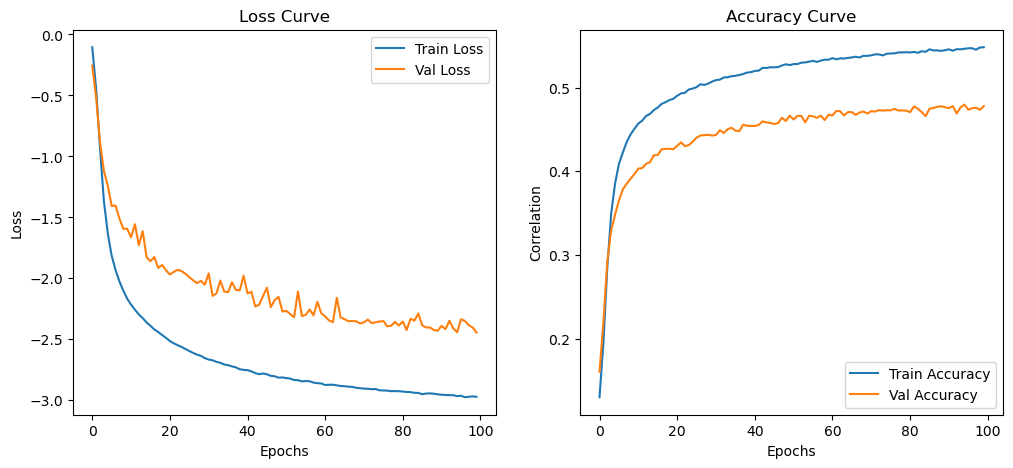

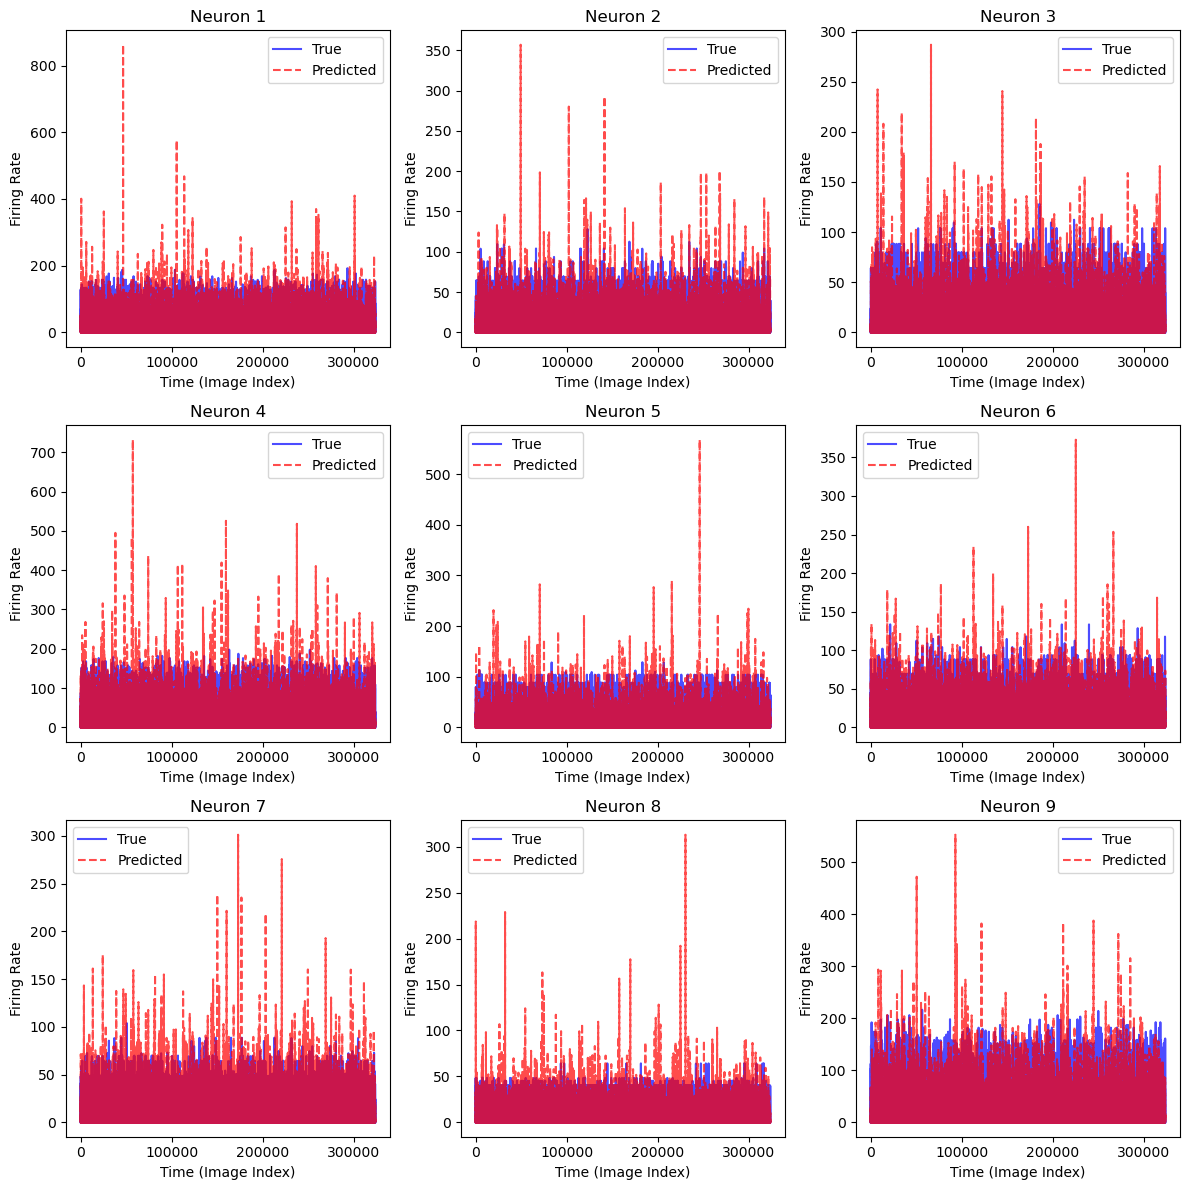

In [8]:
# Define Hyperparameters
hyperparams = {
    'img_shape': (1, 50, 50),
    'chans': [32, 64],
    'ksizes': [5, 5, 3],
    'bias': False,
    'bnorm_d': 2,
    'bn_moment': 0.1,
    'noise': 0.1,
    'activ_fxn': 'ReLU',
    'n_units': 9,
    'gc_bias': False,
    'softplus': False,
    'convgc': False,
    'centers': None
}

h5_path = r'C:\Users\krmri\Downloads\neural_code_data\neural_code_data\ganglion_cell_data\15-10-07\naturalscene.h5'
train_model(h5_path, hyperparams)